In [6]:
import numpy as np
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import sys
import os

# 添加自定义路径
custom_path = os.path.abspath("../script")
if custom_path not in sys.path:
    sys.path.append(custom_path)

from loggoing_tools import *

In [7]:
data_list={
        "retention":["PT3_Level"],		
        "Flow":["PT1_Pressure","PT2_Pressure","FT1_Flow"],
        "skid_water_quality":["QC1_Conductivity","QC2_Conductivity"],
        "detector_level":["UT1_Depth","LT1_Level","PT5_Depth"] ,
        "Temperature":["QC1_Temperature","UT1_Temperature","QC2_Temperature"],                         				
}
sigma_B_list={
        "retention":[0.02],		
        "Flow":[0,0,0],
        "skid_water_quality":[0.001,0.001],
        "detector_level":[0.0008,0.004,0.02] ,
        "Temperature":[0,0.01,0],                         				
}
unit_list={
        "retention":["m"],		
        "Flow":["bar","bar","t/h"],
        "skid_water_quality":["uS/cm","uS/cm"],
        "detector_level":["m","m","m"] ,
        "Temperature":["℃","℃","℃"],                         				
}

In [8]:
columns_dict = read_csv_to_dict('../data/merged.csv')

for key, value in columns_dict.items():
    print(f"{key}: {value[:3]}") 

Date: ['03-10-2024' '03-10-2024' '03-10-2024']
Time: ['17:09:38' '17:09:39' '17:09:40']
Pump_A_Sel_Auto: [1. 1. 1.]
Pump_A_Sel_Man: [0. 0. 0.]
Pump_B_Sel_Auto: [0. 0. 0.]
Pump_B_Sel_Man: [0. 0. 0.]
Pump_A_In_OL: [0 0 0]
Pump_B_In_OL: [0 0 0]
Pump_A_Motor: [0 0 0]
Pump_B_Motor: [0 0 0]
MixTank_High: [0 0 0]
MixTank_Low: [0 0 0]
LeakDetector: [0 0 0]
RemovalTank_High: [0 0 0]
PT1_Pressure: [1. 1. 1.]
QC1_Conductivity: [1. 1. 1.]
QC2_Conductivity: [0. 0. 0.]
FT1_Flow: [0. 0. 0.]
PT2_Pressure: [1.94601 1.94678 1.94513]
UT1_Depth: [2.60895 2.60873 2.60895]
LT1_Level: [3.85798 3.85798 3.85798]
PT3_Level: [1.34616 1.34678 1.34678]
QC1_Temperature: [0.0883969 0.0876563 0.0879031]
PT5_Depth: [0.126696 0.125618 0.126696]
Salinity: [nan nan nan]
TDS: [nan nan nan]
UT1_Conductivity: [nan nan nan]
UT1_Temperature: [nan nan nan]
Fault_Register: [nan nan nan]
Fault_Register_2: [nan nan nan]
Down_Sampled_FT1: [nan nan nan]
QC2_Temperature: [nan nan nan]


In [9]:
seconds_from_start =np.array(calculate_seconds(columns_dict["Date"],columns_dict["Time"]))


In [10]:
division_time=["05:00:00","03:30:00","04:00:00","08:00:00","14:00:00","09:39:00","13:00:00","00:00:00"]
division_date=["29-10-2024","29-10-2024","30-10-2024","05-11-2024","08-11-2024","20-11-2024","20-11-2024","28-11-2024"]
division_second = np.array(calculate_seconds(division_date,division_time))
division_second

array([2203200, 2197800, 2286000, 2818800, 3099600, 4120740, 4132800,
       4777200])

In [11]:
Oct_mask= ((seconds_from_start>=division_second[2]) * (seconds_from_start<=division_second[3])+(seconds_from_start>=division_second[0]) * (seconds_from_start<=division_second[1]))!=0
Nov_mask= (seconds_from_start>=division_second[4]) * (seconds_from_start<=division_second[5])
Nov_mask2= (seconds_from_start>=division_second[6]) * (seconds_from_start<=division_second[7])

In [12]:
colors=['r','b','g','k','purple']

In [13]:
def plot_stability_analysis(mask,start_time:str,data_list=data_list,sigma_B_list=sigma_B_list,unit_list=unit_list):
   
    colors=['r','b','g','k','purple']


    for plot_name, line_names in data_list.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"{plot_name} Plot")

        units = unit_list[plot_name]
        sigma_Bs = sigma_B_list[plot_name]
        y_halfwidth=0

        for c,sigma_B,unit,line_name in zip(colors,sigma_Bs,units,line_names):
            # Get line data
            y = columns_dict[line_name][mask]
            x = seconds_from_start[mask]-seconds_from_start[mask][0]

            # Calculate mean and standard deviation
            mean = np.mean(y)
            std = np.std(y)
            
            glitch_mask = (y<(mean+3*std))*(y>(mean-3*std))

            y=y[glitch_mask]
            x=x[glitch_mask]/3600

            if x.shape[0]==0:
                continue

            mean = np.mean(y)
            std = np.std(y)

            # Perform linear fitting
            coeffs = np.polyfit(x, y, 1)  # Linear polynomial fit
            linear_fit = np.polyval(coeffs, x)

            # Calculate slope standard deviation
            residuals = y - linear_fit
            residual_variance = np.sum(residuals**2+sigma_B**2) / (len(y) - 2)
            x_mean = np.mean(x)
            slope_std = np.sqrt(residual_variance / np.sum((x - x_mean)**2))

            print(line_name+":")
            print(f"Mean:{mean:.3f} "+unit)
            print(f"Relative RMS:{std/mean*100:.3f}% mean value")
            print(f"Relative Slope:({coeffs[0]/mean*24*12*100:.2f}±{slope_std/mean*24*12*100:0.2f})% mean value per month")
            # Plot original data
            plt.plot(x[0::7200], (y[0::7200]/mean-1)*100, label=f"{line_name} Data",color=c)

            # Plot linear fit line
            plt.plot(x, (linear_fit/mean-1)*100, linestyle="--", label=f"{line_name} Linear Fit",color=c)

            # Plot mean ± standard deviation region
            plt.fill_between(x, -std/mean*100, + std/mean*100, color=c, alpha=0.3, label=f"{line_name} ± STD")

            if std/mean>y_halfwidth:
                y_halfwidth=std/mean
            

        # Add legend and labels
        plt.ylim(-150*y_halfwidth,150*y_halfwidth)
        plt.xlabel("hours from "+start_time)
        plt.ylabel("Relative error(%)")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        
        # Show or save the plot
        plt.show()
    return None


PT3_Level:
Mean:0.442 m
Relative RMS:0.196% mean value
Relative Slope:(-0.23±0.04)% mean value per month


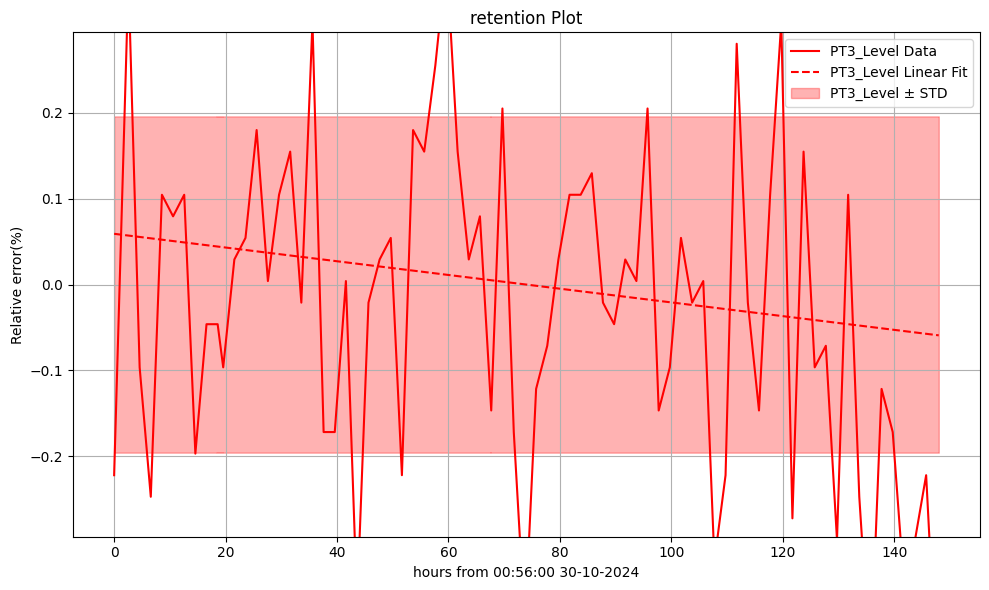

PT1_Pressure:
Mean:4.599 bar
Relative RMS:0.165% mean value
Relative Slope:(0.24±0.00)% mean value per month
PT2_Pressure:
Mean:1.080 bar
Relative RMS:0.556% mean value
Relative Slope:(0.06±0.01)% mean value per month
FT1_Flow:
Mean:2.264 t/h
Relative RMS:1.287% mean value
Relative Slope:(-0.17±0.01)% mean value per month


/tmp/ipykernel_18294/1636667667.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mingzhuo/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


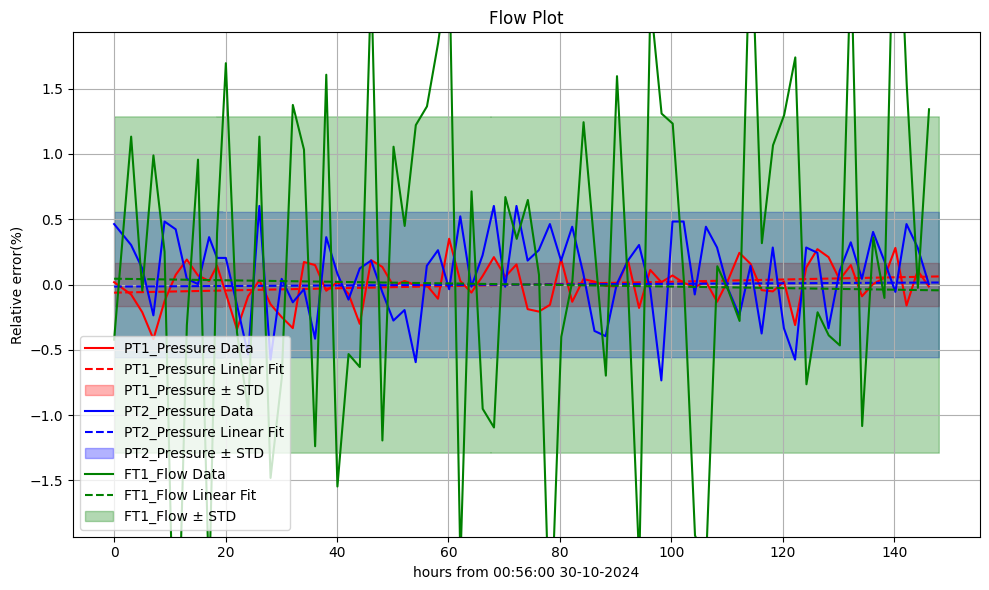

QC1_Conductivity:
Mean:0.096 uS/cm
Relative RMS:13.360% mean value
Relative Slope:(-16.87±0.12)% mean value per month
QC2_Conductivity:
Mean:0.056 uS/cm
Relative RMS:5.880% mean value
Relative Slope:(-5.45±0.06)% mean value per month


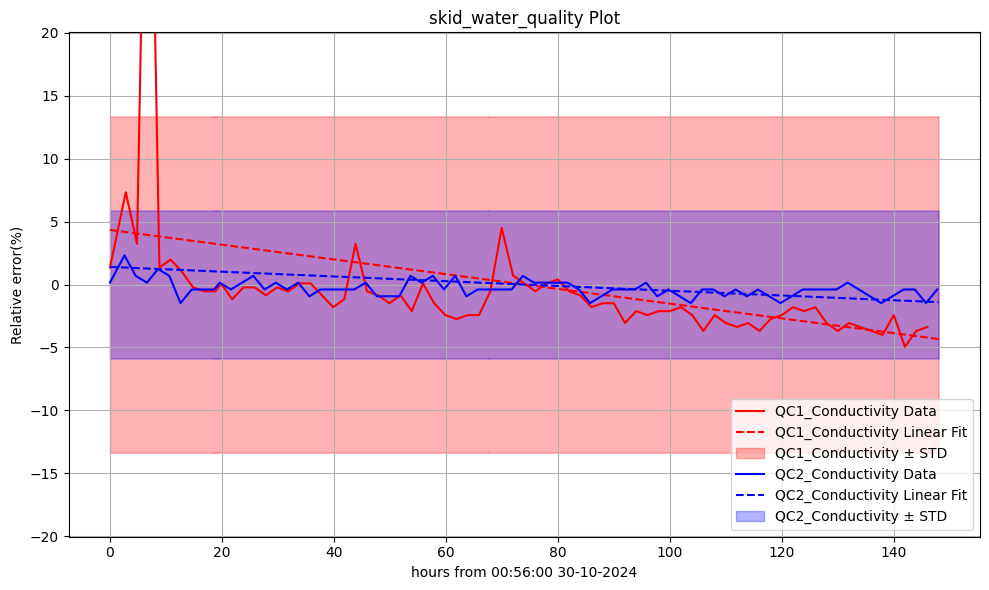

UT1_Depth:
Mean:3.295 m
Relative RMS:0.031% mean value
Relative Slope:(0.09±0.00)% mean value per month
LT1_Level:
Mean:3.296 m
Relative RMS:0.040% mean value
Relative Slope:(0.08±0.00)% mean value per month
PT5_Depth:
Mean:3.226 m
Relative RMS:0.139% mean value
Relative Slope:(0.09±0.01)% mean value per month


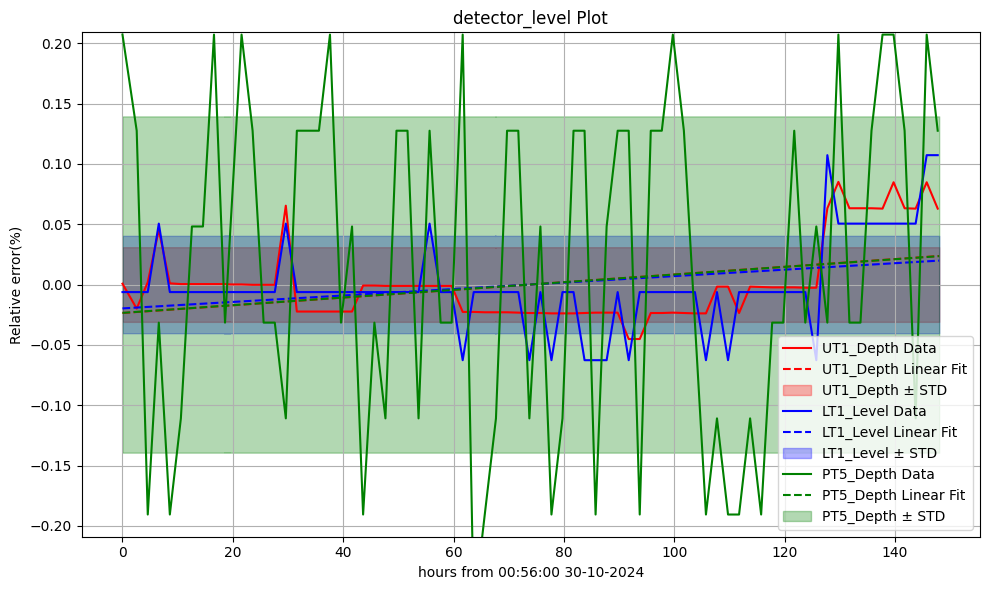

QC1_Temperature:
Mean:14.362 ℃
Relative RMS:0.753% mean value
Relative Slope:(-3.55±0.01)% mean value per month
UT1_Temperature:
Mean:13.684 ℃
Relative RMS:0.355% mean value
Relative Slope:(-2.26±0.00)% mean value per month


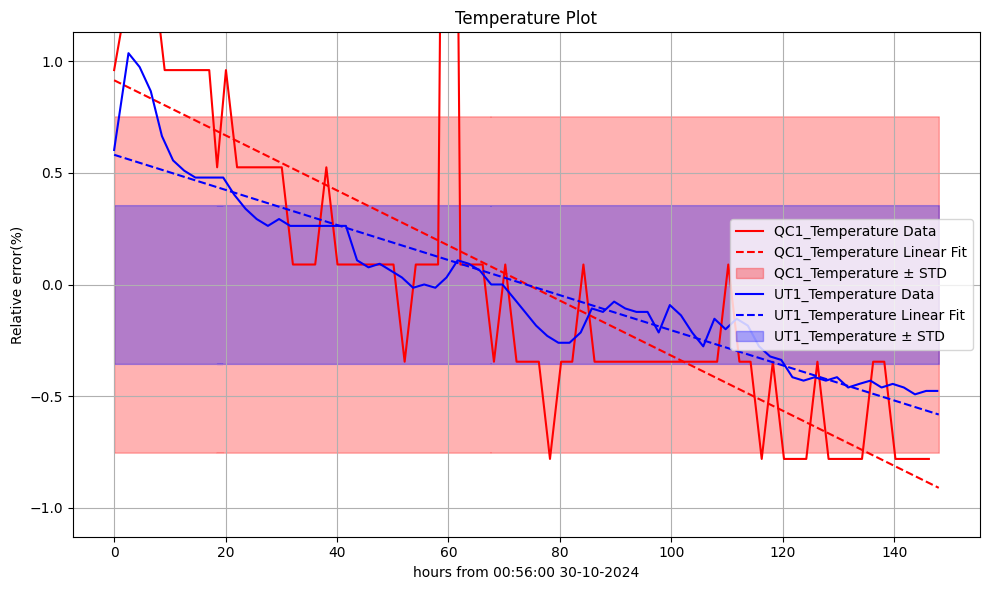

In [14]:
plot_stability_analysis(Oct_mask,"00:56:00 30-10-2024")

PT3_Level:
Mean:0.442 m
Relative RMS:0.200% mean value
Relative Slope:(-0.02±0.02)% mean value per month


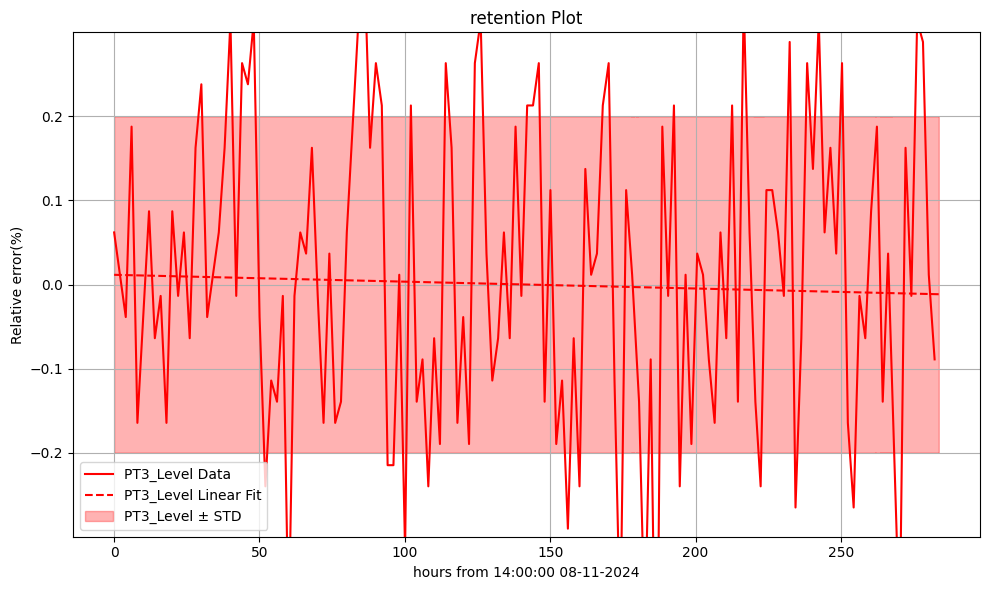

PT1_Pressure:
Mean:4.653 bar
Relative RMS:0.145% mean value
Relative Slope:(0.12±0.00)% mean value per month
PT2_Pressure:
Mean:1.101 bar
Relative RMS:0.569% mean value
Relative Slope:(0.76±0.00)% mean value per month
FT1_Flow:
Mean:2.322 t/h
Relative RMS:1.273% mean value
Relative Slope:(0.17±0.00)% mean value per month


/tmp/ipykernel_18294/1636667667.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


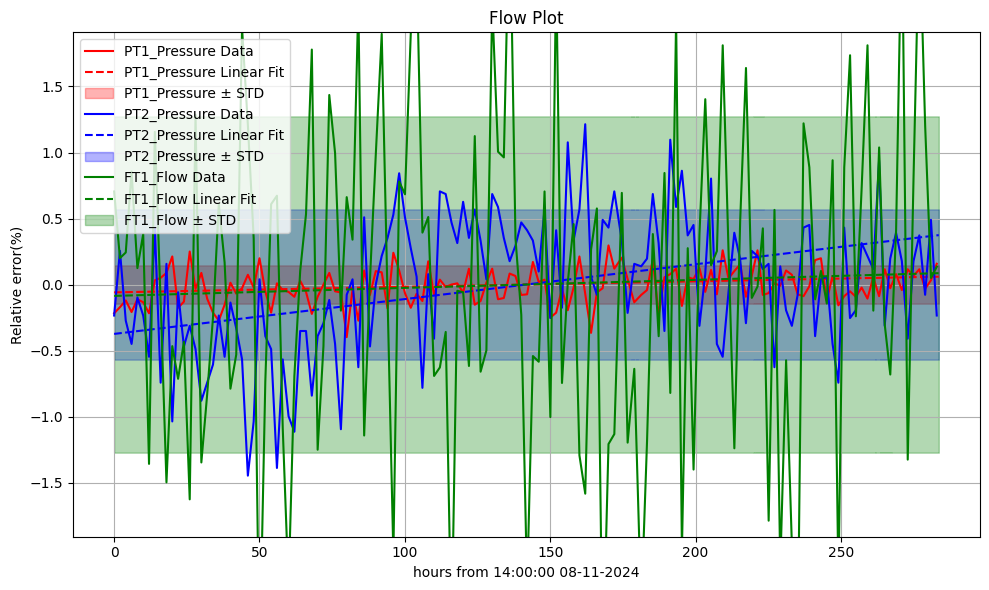

QC1_Conductivity:
Mean:0.093 uS/cm
Relative RMS:6.197% mean value
Relative Slope:(-5.56±0.02)% mean value per month
QC2_Conductivity:
Mean:0.055 uS/cm
Relative RMS:2.142% mean value
Relative Slope:(-1.30±0.01)% mean value per month


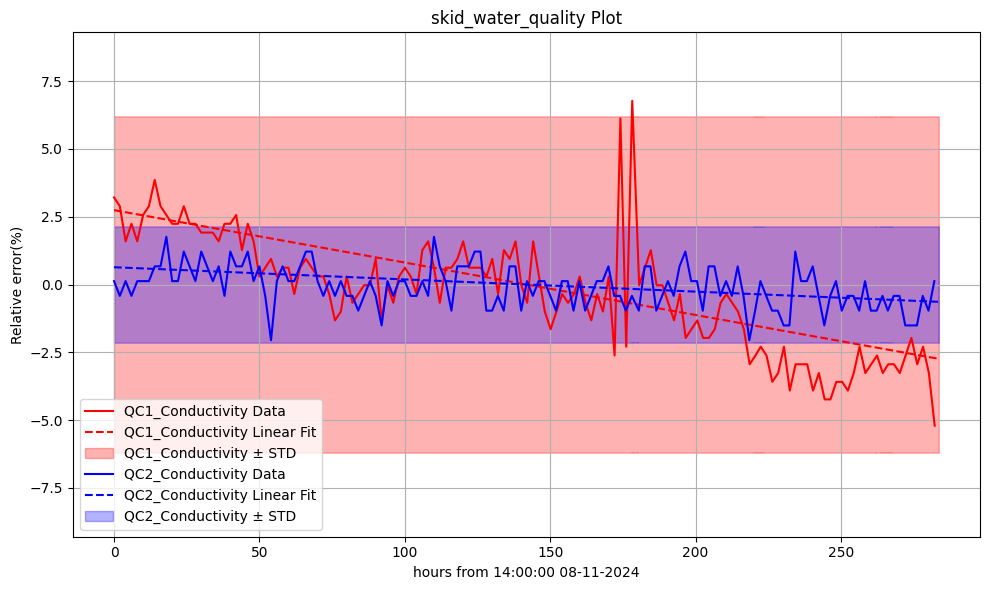

UT1_Depth:
Mean:3.296 m
Relative RMS:0.033% mean value
Relative Slope:(0.02±0.00)% mean value per month
LT1_Level:
Mean:3.299 m
Relative RMS:0.041% mean value
Relative Slope:(0.03±0.00)% mean value per month
PT5_Depth:
Mean:3.226 m
Relative RMS:0.137% mean value
Relative Slope:(-0.05±0.00)% mean value per month


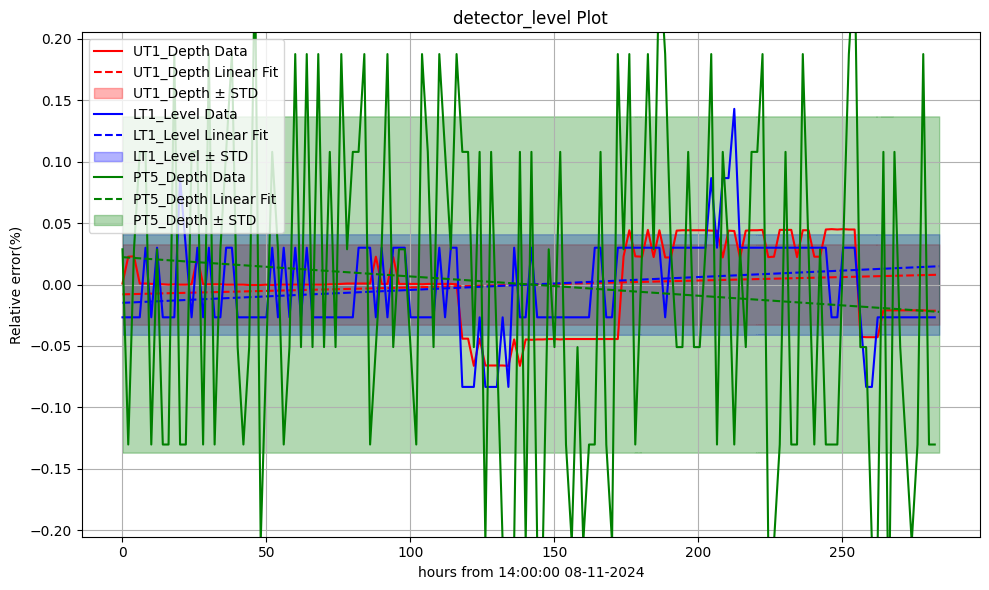

QC1_Temperature:
Mean:14.751 ℃
Relative RMS:0.701% mean value
Relative Slope:(0.14±0.00)% mean value per month
UT1_Temperature:
Mean:13.954 ℃
Relative RMS:0.176% mean value
Relative Slope:(0.20±0.00)% mean value per month
QC2_Temperature:
Mean:13.209 ℃
Relative RMS:0.747% mean value
Relative Slope:(0.23±0.00)% mean value per month


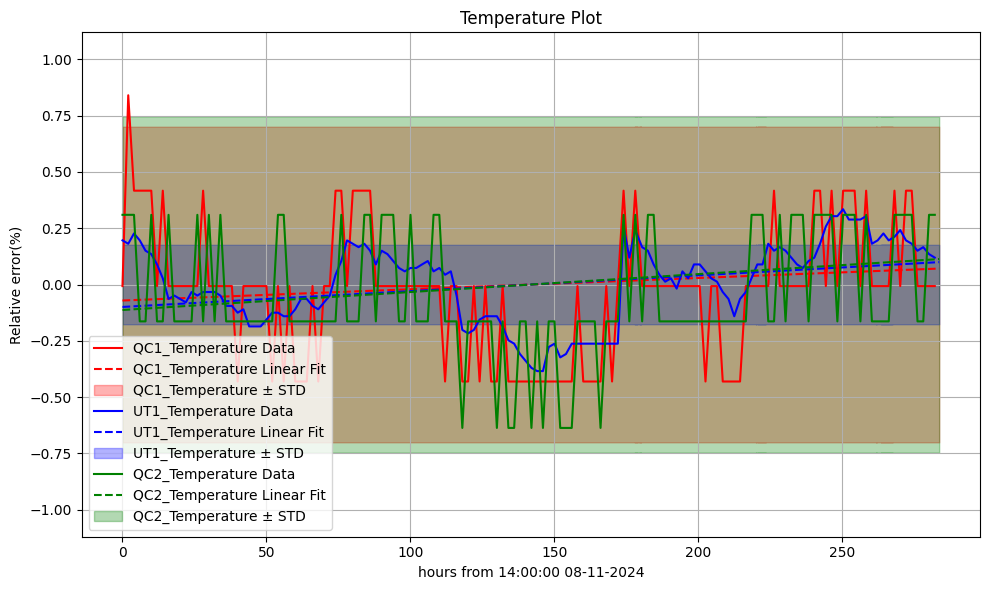

In [15]:
plot_stability_analysis(Nov_mask,"14:00:00 08-11-2024")

PT3_Level:
Mean:0.443 m
Relative RMS:0.282% mean value
Relative Slope:(1.19±0.04)% mean value per month


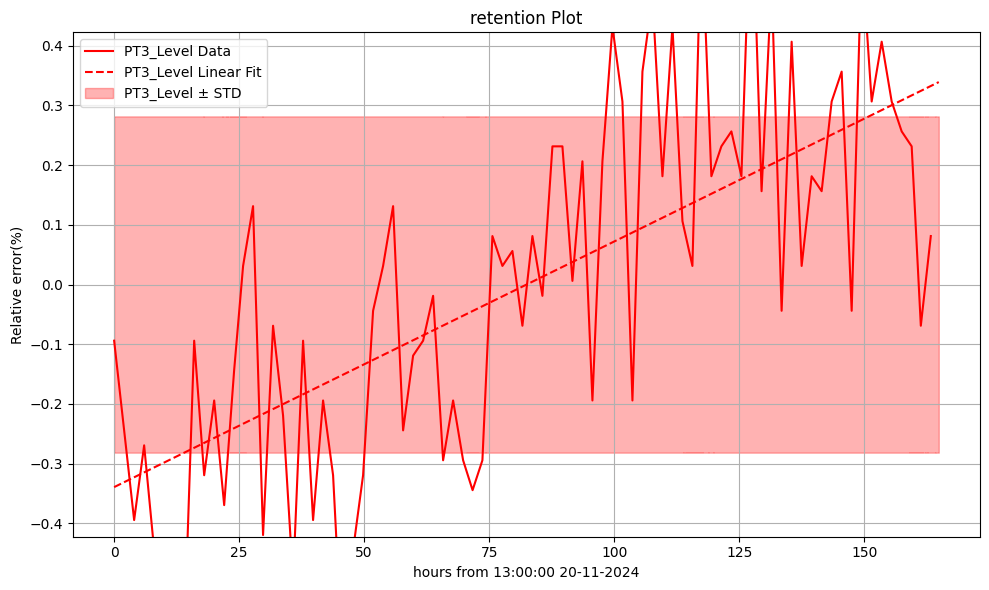

PT1_Pressure:
Mean:4.588 bar
Relative RMS:0.137% mean value
Relative Slope:(0.01±0.00)% mean value per month
PT2_Pressure:
Mean:1.076 bar
Relative RMS:0.416% mean value
Relative Slope:(0.25±0.00)% mean value per month
FT1_Flow:
Mean:2.271 t/h
Relative RMS:1.233% mean value
Relative Slope:(-0.18±0.01)% mean value per month


/tmp/ipykernel_18294/1636667667.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


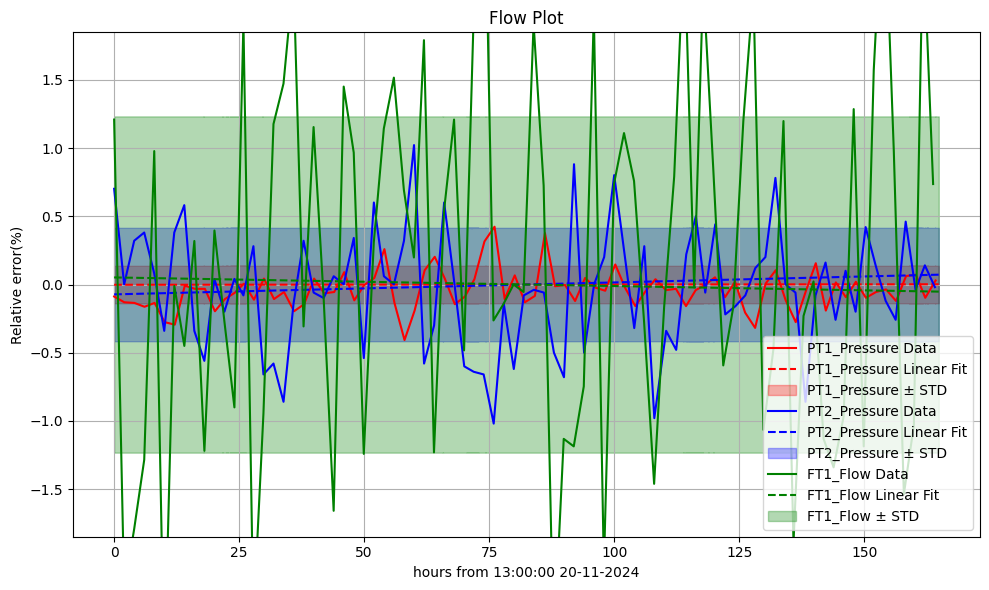

QC1_Conductivity:
Mean:0.087 uS/cm
Relative RMS:2.431% mean value
Relative Slope:(-10.93±0.02)% mean value per month
QC2_Conductivity:
Mean:0.055 uS/cm
Relative RMS:0.786% mean value
Relative Slope:(-2.39±0.02)% mean value per month


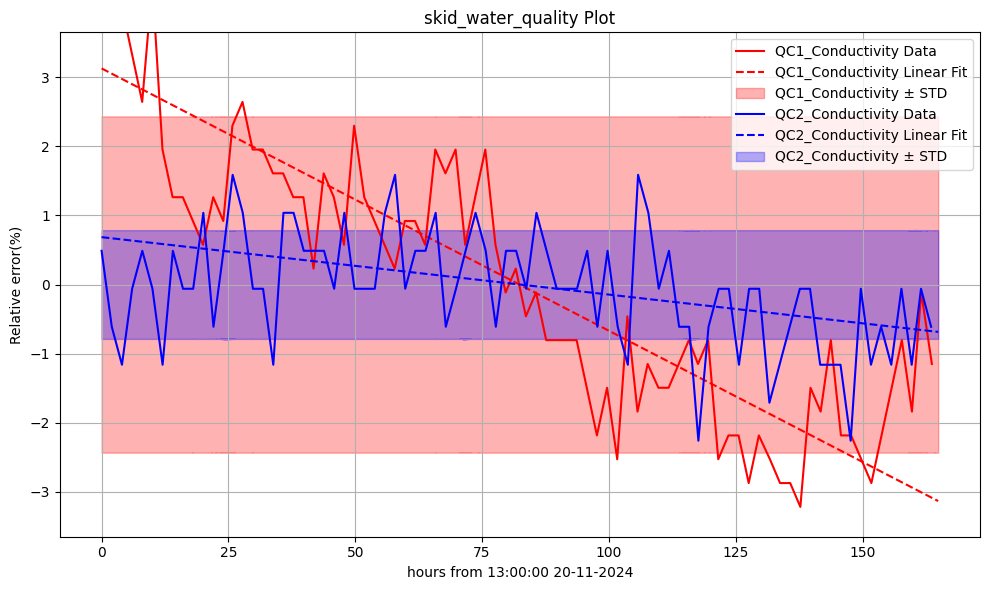

UT1_Depth:
Mean:3.294 m
Relative RMS:0.031% mean value
Relative Slope:(-0.09±0.00)% mean value per month
LT1_Level:
Mean:3.296 m
Relative RMS:0.064% mean value
Relative Slope:(-0.22±0.00)% mean value per month
PT5_Depth:
Mean:3.221 m
Relative RMS:0.143% mean value
Relative Slope:(-0.21±0.00)% mean value per month


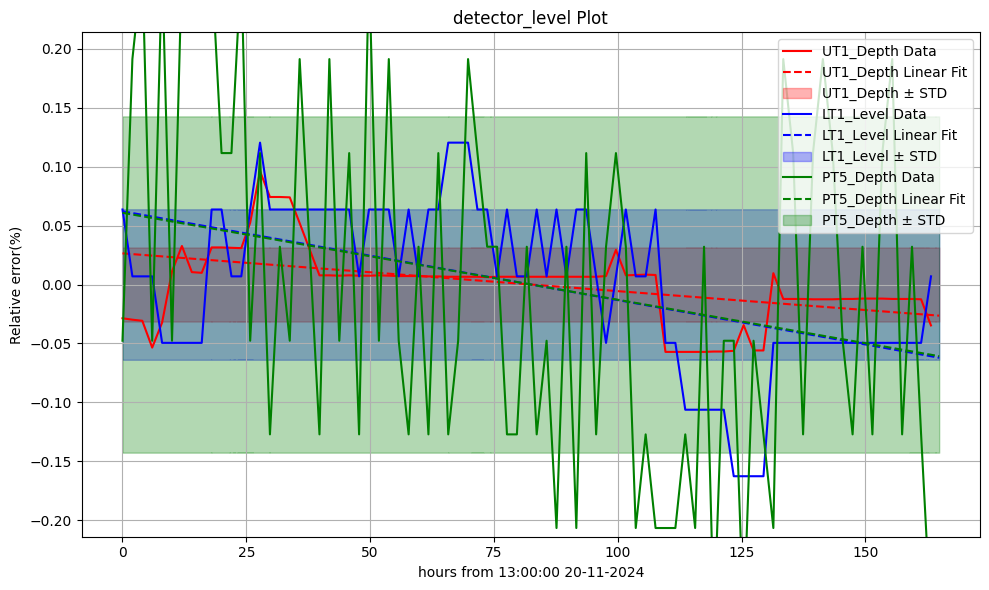

QC1_Temperature:
Mean:14.699 ℃
Relative RMS:0.804% mean value
Relative Slope:(-0.03±0.01)% mean value per month
UT1_Temperature:
Mean:13.892 ℃
Relative RMS:0.454% mean value
Relative Slope:(0.09±0.00)% mean value per month
QC2_Temperature:
Mean:13.142 ℃
Relative RMS:0.367% mean value
Relative Slope:(0.20±0.00)% mean value per month


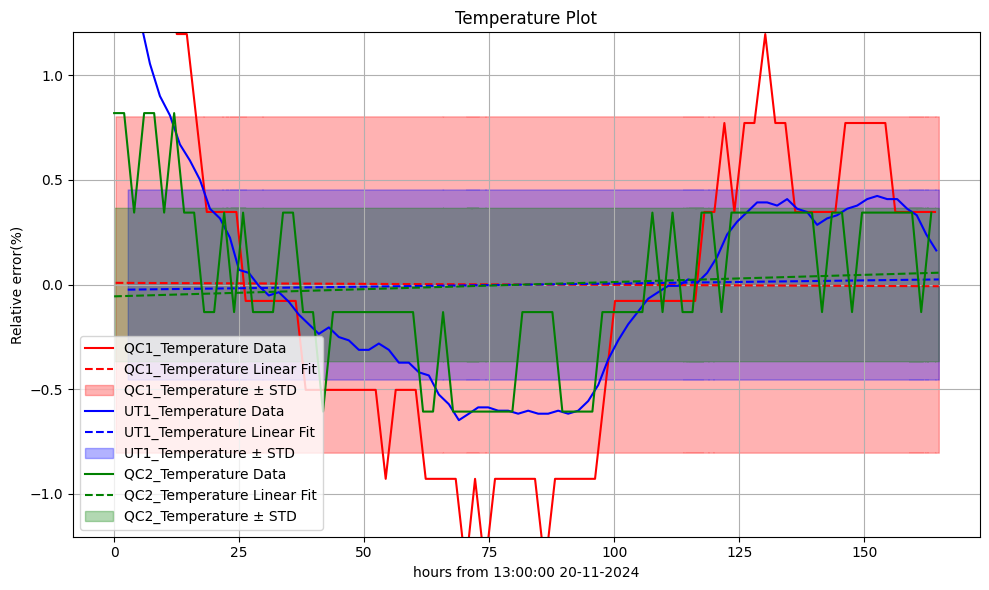

In [16]:
plot_stability_analysis(Nov_mask2,"13:00:00 20-11-2024")

PT3_Level:
Mean:0.442 m
Relative RMS:0.262% mean value
Relative Slope:(0.11±0.00)% mean value per month


/tmp/ipykernel_18294/1636667667.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


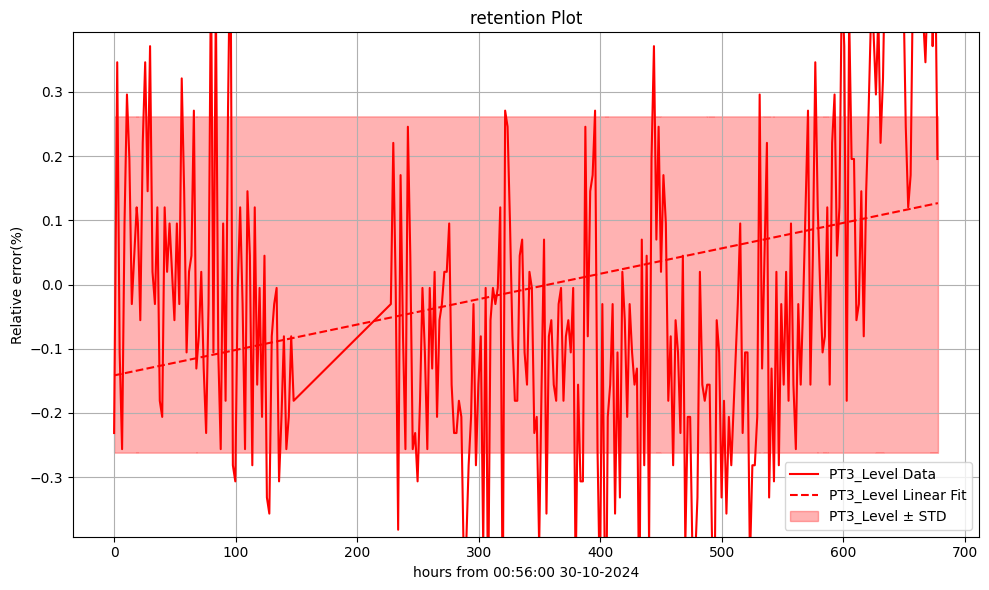

PT1_Pressure:
Mean:4.621 bar
Relative RMS:0.667% mean value
Relative Slope:(-0.06±0.00)% mean value per month
PT2_Pressure:
Mean:1.089 bar
Relative RMS:1.179% mean value
Relative Slope:(-0.06±0.00)% mean value per month
FT1_Flow:
Mean:2.294 t/h
Relative RMS:1.746% mean value
Relative Slope:(0.23±0.00)% mean value per month


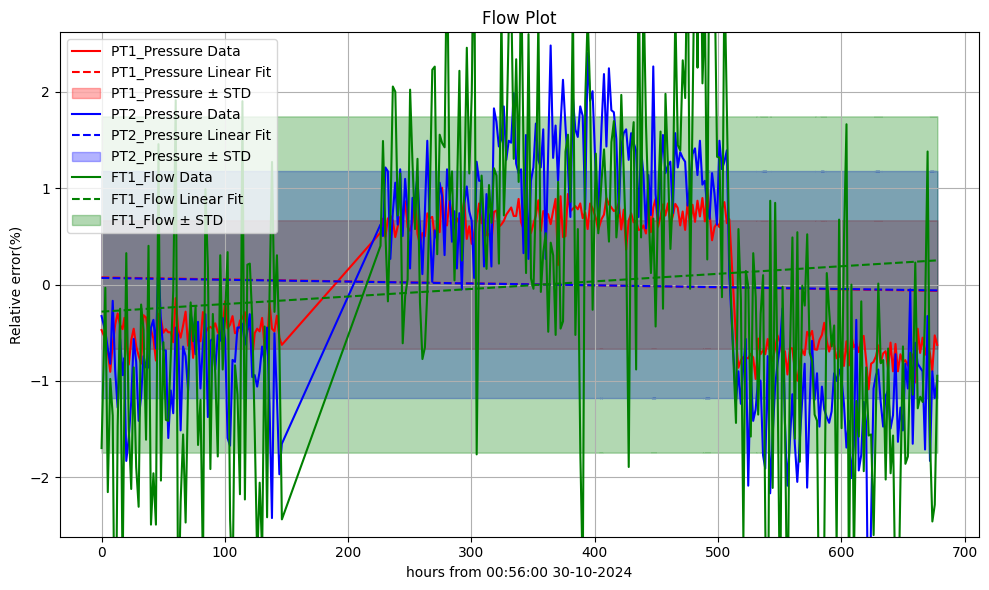

QC1_Conductivity:
Mean:0.092 uS/cm
Relative RMS:8.545% mean value
Relative Slope:(-4.77±0.01)% mean value per month
QC2_Conductivity:
Mean:0.055 uS/cm
Relative RMS:3.339% mean value
Relative Slope:(-0.90±0.00)% mean value per month


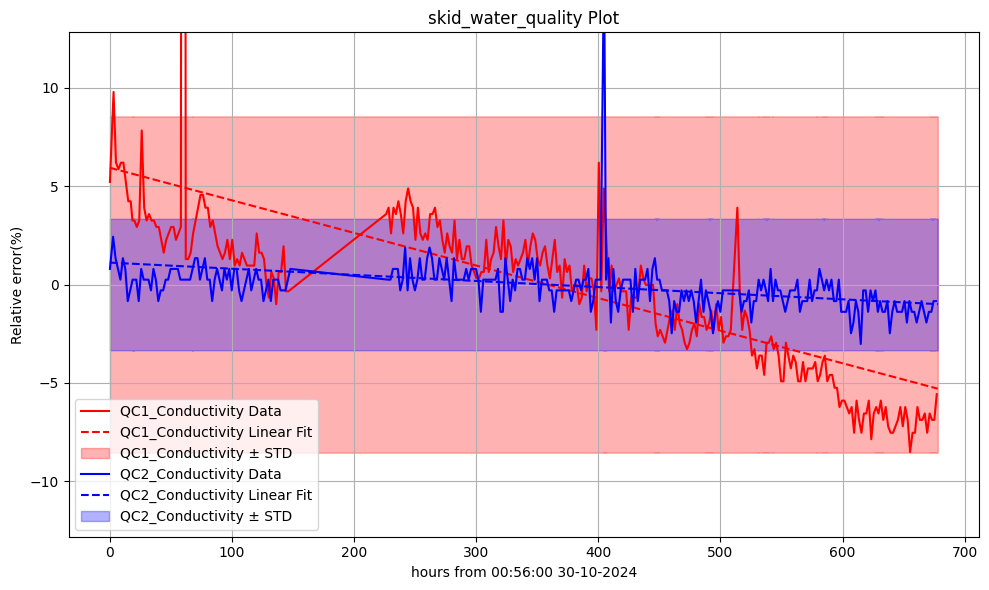

UT1_Depth:
Mean:3.295 m
Relative RMS:0.039% mean value
Relative Slope:(-0.01±0.00)% mean value per month
LT1_Level:
Mean:3.297 m
Relative RMS:0.064% mean value
Relative Slope:(-0.00±0.00)% mean value per month
PT5_Depth:
Mean:3.225 m
Relative RMS:0.156% mean value
Relative Slope:(-0.07±0.00)% mean value per month


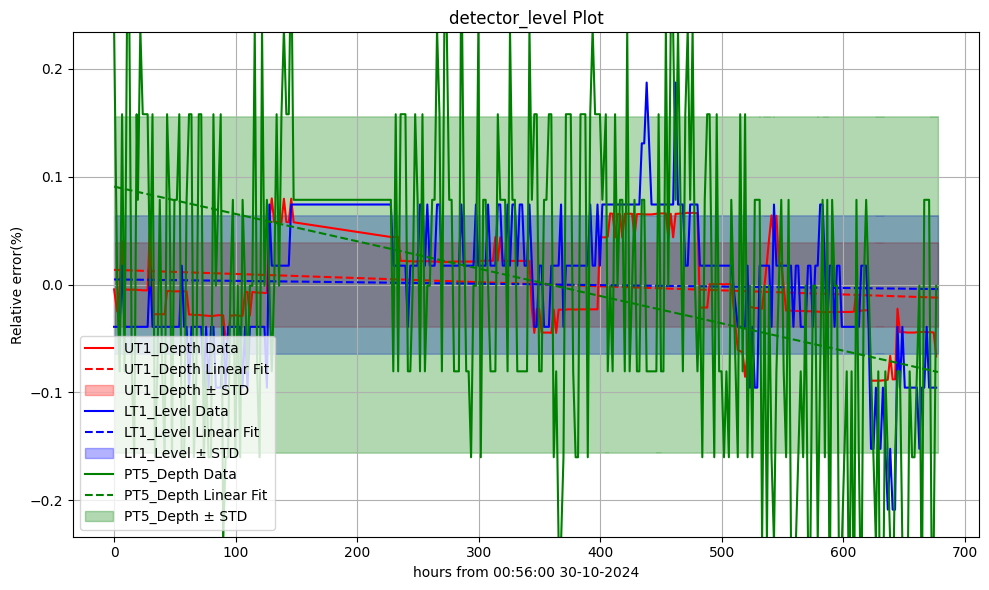

QC1_Temperature:
Mean:14.642 ℃
Relative RMS:1.384% mean value
Relative Slope:(1.14±0.00)% mean value per month
UT1_Temperature:
Mean:13.871 ℃
Relative RMS:0.866% mean value
Relative Slope:(0.78±0.00)% mean value per month


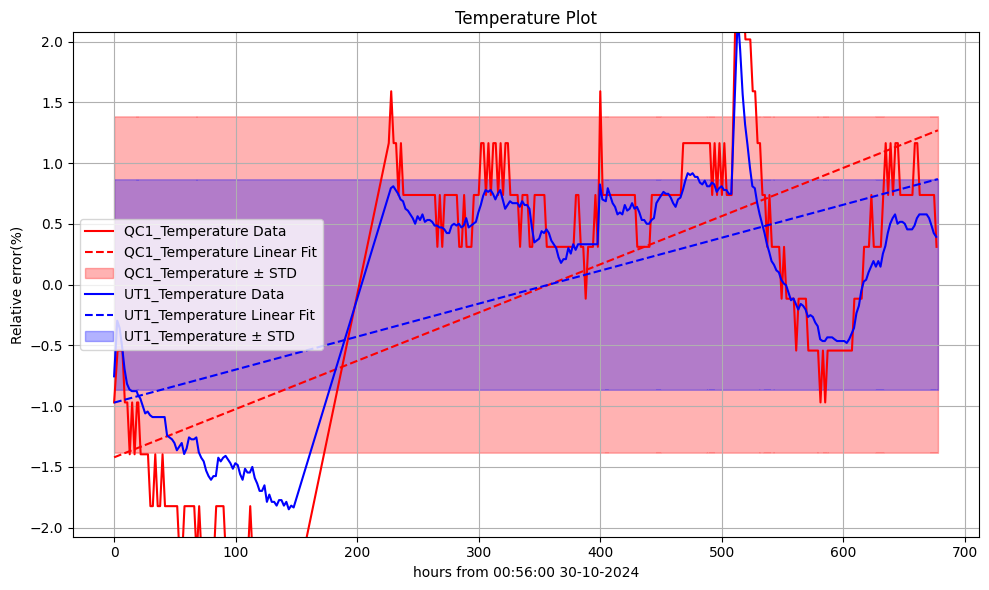

In [17]:
plot_stability_analysis(Oct_mask+Nov_mask+Nov_mask2,"00:56:00 30-10-2024")